In [17]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import time
import QuantLib as ql 
####
from instruments.EuropeanOptions import *
from engines.blacksimple import *

## Option Parameters

In [11]:
# Sample data
spot_price = 100.0
strike_price = 100.0
maturity = 1.0
option_type = "Call"
risk_free_rate = 0.03
volatility = 0.2

## Closed Form

In [12]:
# Create an instrument-object for the European Call Option 
call_option = EuropeanCallOption(strike_price, maturity, option_type)
# Create an engine-object for the Black-Scholes model
bs_engine = BlackScholesPricing(call_option, spot_price, risk_free_rate, volatility)
# Calculate the call option price
call_option_price = bs_engine.calculate_option_price()
print(f"Call Option Price: {call_option_price.numpy()}")
print("*"*30)

# Calculate Delta and Vega using automatic differentiation
price, sensy = bs_engine.calculate_aad()
print("Black AAD: ")
print("Price: ", price.numpy())
print(f"Delta: {sensy[0].numpy()}")
print(f"Vega: {sensy[1].numpy()}")
print(f"Rho: {sensy[2].numpy()}")

print("*"*30)
print("*"*30)
# Calculate Delta and Vega using automatic differentiation
price_xla, sensy_xla = bs_engine.calculate_aad_xla()
print("Black AAD XLA: ")
print("Price: ", price_xla.numpy())
print(f"Delta: {sensy_xla[0].numpy()}")
print(f"Vega: {sensy_xla[1].numpy()}")
print(f"Rho: {sensy_xla[2].numpy()}")

Call Option Price: 9.413406372070312
******************************
Black AAD: 
Price:  9.413406
Delta: 0.5987063646316528
Vega: 38.666812896728516
Rho: 50.45722961425781
******************************
******************************
Black AAD XLA: 
Price:  9.413406
Delta: 0.5987063646316528
Vega: 38.666812896728516
Rho: 50.45722961425781


## MC Simulation

In [13]:
n_path = 20000
timesteps = 100
z = tf.random.normal((n_path, timesteps), seed=12)

mc_engine = EuropeanKernel(call_option, spot_price, risk_free_rate, volatility, z)

In [14]:
call_option_price = mc_engine.calculate_option_price()
print(f"Call Option MC Price: {call_option_price.numpy()}")
print("*"*30)
# Calculate Delta and Vega using automatic differentiation
price, sensy = mc_engine.calculate_aad()
print("Black AAD MC: ")
print("Price: ", price.numpy())
print(f"Delta: {sensy[0].numpy()}")
print(f"Vega: {sensy[1].numpy()}")
print(f"Rho: {sensy[2].numpy()}")

print("*"*30)
print("*"*30)
# Calculate Delta and Vega using automatic differentiation
price_xla, sensy_xla = mc_engine.calculate_aad_xla()
print("Black AAD MC XLA: ")
print("Price: ", price_xla.numpy())
print(f"Delta: {sensy_xla[0].numpy()}")
print(f"Vega: {sensy_xla[1].numpy()}")
print(f"Rho: {sensy_xla[2].numpy()}")

Call Option MC Price: 9.448568344116211
******************************
Black AAD MC: 
Price:  9.448568
Delta: 0.5953810811042786
Vega: 38.992950439453125
Rho: 50.08954620361328
******************************
******************************
Black AAD MC XLA: 
Price:  9.448568
Delta: 0.5953811407089233
Vega: 38.99294662475586
Rho: 50.089542388916016


### Performances: QuantLib vs TensorFlow

In [15]:
def EuropeanKernelQl(n_path, timesteps, spot_price, risk_free_rate, volatility, strike_price):
    calculation_date = ql.Date(1, 1, 2010)
    ql.Settings.instance().evaluationDate = calculation_date
    maturity_date = ql.Date(1, 1, 2011)
    day_count = ql.Thirty360(ql.Thirty360.BondBasis)
    calendar = ql.NullCalendar()

    volatility_ql = ql.SimpleQuote(volatility)
    option_type = ql.Option.Call

    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option_ql = ql.VanillaOption(payoff, eu_exercise)

    flat_ts = ql.YieldTermStructureHandle( ql.FlatForward(calculation_date, risk_free_rate, day_count) )
    flat_vol_ts = ql.BlackVolTermStructureHandle( ql.BlackConstantVol(calculation_date, calendar, ql.QuoteHandle(volatility_ql), day_count) )

    spot_handle = ql.QuoteHandle( ql.SimpleQuote(spot_price) )
    bsm_process = ql.BlackScholesProcess(spot_handle, flat_ts, flat_vol_ts)

    # Compute the same price number_of_options times

    engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                timeSteps= timesteps,
                                requiredSamples= n_path,
                                seed=12)

    european_option_ql.setPricingEngine(engine)
    return european_option_ql



In [16]:
n_path = 100000
timesteps = 100
z = tf.random.normal((n_path, timesteps), seed=12)


mc_engine_ql = EuropeanKernelQl(n_path, timesteps, spot_price, risk_free_rate, volatility, strike_price)
mc_engine = EuropeanKernel(call_option, spot_price, risk_free_rate, volatility, z)

# Price
t = time.time()
price_ql = mc_engine_ql.NPV()
print("Time (seconds) to price a European Call Option using QuantLib: ", time.time() - t)

t = time.time()
price_tf = mc_engine.calculate_option_price()
print("Time (seconds) to price a European Call Option using TensorFlow: ", time.time() - t)

t = time.time()
price_xla = mc_engine.calculate_option_price_xla()
print("Time (seconds) to price a European Call Option using XLA: ", time.time() - t)

Time (seconds) to price a European Call Option using QuantLib:  2.6102826595306396
Time (seconds) to price a European Call Option using TensorFlow:  0.06581878662109375
Time (seconds) to price a European Call Option using XLA:  0.3190290927886963


In [9]:
def test_runtime(paths):
    
    runtime_ql = []
    runtime_tf = []
    runtime_xla = []

    price_ql = []
    price_tf = []
    price_xla = []

    for i in range(0, len(paths)):
        n_path = paths[i]
        print(n_path)
        timesteps = 100
        z = tf.random.normal((n_path, timesteps), seed=12)


        mc_engine_ql = EuropeanKernelQl(n_path, timesteps, spot_price, risk_free_rate, volatility, strike_price)
        mc_engine = EuropeanKernel(call_option, spot_price, risk_free_rate, volatility, z)

        t = time.time()
        npv_ql = mc_engine_ql.NPV()
        runtime = time.time() - t
        runtime_ql.append(runtime)
        price_ql.append(npv_ql)

        t = time.time()
        npv_tf = mc_engine.calculate_option_price()
        runtime = time.time() - t
        runtime_tf.append(runtime)
        price_tf.append(npv_tf)

        t = time.time()
        npv_xla = mc_engine.calculate_option_price_xla()
        runtime = time.time() - t
        runtime_xla.append(runtime)
        price_xla.append(npv_xla)

    return [runtime_ql, runtime_tf, runtime_xla], [npv_ql, npv_tf, npv_xla]

paths = [1000, 10000, 30000, 80000, 100000, 200000, 500000, 800000, 1000000]
times, npvs = test_runtime(paths)

1000
10000
30000
80000
100000
200000
500000
800000
1000000


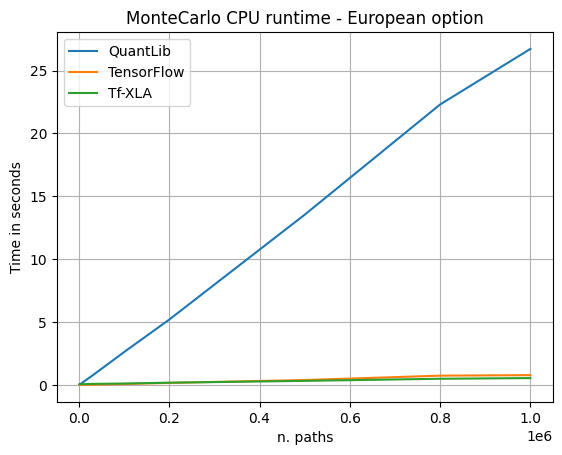

In [11]:

#plt.plot(runtime_ql, paths)
plt.plot(paths, times[0], label = 'QuantLib')
plt.plot(paths, times[1],  label = 'TensorFlow')
plt.plot(paths, times[2],  label = 'Tf-XLA')
plt.title("MonteCarlo CPU runtime - European option")
plt.xlabel("n. paths")
plt.ylabel("Time in seconds")
plt.grid()
plt.legend()
plt.show()